In [1]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [58]:
def load_data(filename):
    """function to load data"""
    x = scipy.io.loadmat(filename)['PDmean'][20:100,1:49:4]*100 #loading data only for 15 deg per sec
    return x

In [59]:
global T4_Arclight, T4_Gcamp #global varaiables to hold Arclight and Gcamp data

filename = 'data/T4c_ArcLight/ARCOri_Velocity_Mean.mat' 
T4_Arclight = load_data(filename)  #load Arclight data

filename = 'data/T4c_GCaMP/Ori_Mean_Velocity.mat'
T4_Gcamp = load_data(filename)  #load Gcamp data

In [9]:
def plot_data(data_list, dt=0.0769, fig_size=(10,5), speed=[15,30,60,120], title='', savefig=False, c=['k','r']):
    """Plots data for multiple datsets"""
    n_col = len(speed) #number of columns i.e. number of speed stimuli
    n_sti = data_list[0].shape[1] #number of orientations
    #x_values = np.arange(data_list[0].shape[0]) * dt #changing x-axis to time. multiply with time step dt = 1/frequency
    f, ax = plt.subplots(int(n_sti/n_col), int(n_col), sharex=True, sharey= True, figsize=fig_size)
    c_count = 0 #color count for different dataset
    for data in data_list:
        count = 0 #count for stimuli
        for i in range(int(n_sti/n_col)):
            for j in range(n_col):
                #ax[i, j].plot(x_values, data[:, count], color=c[c_count])
                ax[i, j].plot(data[:, count], color=c[c_count])
                count = count + 1
        c_count += 1
    plt.suptitle(title, fontsize=15)
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    if savefig:
        plt.savefig('figures/'+title+'.pdf',dpi=1000);
        
def plot_data_twinaxis(data_list, dt=0.0769, fig_size=(10,5), speed=[15,30,60,120], title='', savefig=False, c=['k','r']):
    """Plots data for multiple datsets"""
    n_col = len(speed) #number of columns i.e. number of speed stimuli
    n_sti = data_list[0].shape[1] #number of orientations
    x_values = np.arange(data_list[0].shape[0]) * dt #changing x-axis to time. multiply with time step dt = 1/frequency
    f, ax = plt.subplots(int(n_sti/n_col), int(n_col), sharex=True, sharey= True, figsize=fig_size)
    c_count = 0 #color count for different dataset
    for data in data_list:
        count = 0 #count for stimuli
        for i in range(int(n_sti/n_col)):
            for j in range(n_col):
                if c_count == 0:
                    ax[i, j].plot(x_values, data[:, count], color=c[c_count])
                else :
                    ax1 = ax[i,j].twinx()
                    ax1.plot(x_values, data[:, count], color=c[c_count])
                    #ax1.set_ylim(-20,250)
                #ax[i, j].plot(data[:, count], color=c[c_count])
                count = count + 1
        c_count += 1
    plt.suptitle(title, fontsize=15)
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    if savefig:
        plt.savefig('figures/'+title+'.pdf',dpi=1000);

In [43]:
def lowpass(x, tau, dt):
    y = np.zeros_like(x)
    n = x.shape[0]   #length of time dimension
    alpha = dt / (tau+dt)
    y[0] = x[0]
    for i in np.arange(1,n):
        y[i] = alpha*x[i] + (1-alpha)*y[i-1]
    return y

def highpass(x, tau, dt):
    y = x - lowpass(x, tau, dt)
    return y

def bandpass(x, tauhp, taulp, dt):
    y = highpass(x, tauhp, dt)
    y = lowpass(y, taulp, dt)
    return y

def threshold_cut(x, thres):
    x_copy = x.copy()
    x_copy[x_copy<thres] = 0
    return x_copy 

def Ca_model(x, thres, tauhp, taulp1, gain1, taulp2, gain2, dt=0.0769):
    x_thres = threshold_cut(x,thres)
    x_thres_bp1 = bandpass(x_thres, tauhp, taulp1, dt)
    x_1 = x_thres_bp1 * gain1
    x_thres_bp2 = bandpass(x_thres, tauhp, taulp2, dt)
    x_2 = x_thres_bp2 * gain2
    y = x_1 + x_2
    #y = np.roll(y, int(tshift), axis=0)
    return y

def Ca_model_1(x, thres, tauhp, taulp1, gain1, dt=0.0769):
    x_thres = threshold_cut(x,thres)
    x_thres_hp = highpass(x_thres, tauhp, dt)
    x_thres_hp_lp = lowpass(x_thres_hp, taulp1, dt)
    y = x_thres_hp_lp * gain1
    return y

def Ca_model_2(x, thres, tauhp, taulp1, taulp2, gain, dt=0.0769):
    x_thres = threshold_cut(x, thres)
    x_thres_hp = highpass(x_thres, tauhp, dt)
    x_thres_hp_lp1 = lowpass(x_thres_hp, taulp1, dt)
    #x_thres_hp_lp1 = shift_signal(x_thres_hp_lp1, T4Ca_model, vel=15.0)
    x_thres_hp_lp2 = lowpass(x_thres_hp, taulp2, dt) 
    #x_thres_hp_lp2 = shift_signal(x_thres_hp_lp2, T4Ca_model, vel=15.0)
    y = (x_thres_hp_lp1 + x_thres_hp_lp2)*gain
    #plot_data([x, x_thres, x_thres_hp, x_thres_hp_lp1, x_thres_hp_lp2, y], c=['k','r','g','blue','brown','grey']);
    return y

def shift_signal(gcamp_data, model_data, vel):
    if vel == 15.0:
        shift_columns = np.argmax(gcamp_data[45:70,:],axis=0)-np.argmax(model_data[45:70,:],axis=0)
    elif vel == 30.0:
        shift_columns = np.argmax(gcamp_data[15:25,:],axis=0)-np.argmax(model_data[15:25,:],axis=0)
    A = model_data
    r = shift_columns
    rows, columns = np.ogrid[:A.shape[0], :A.shape[1]]
    r[r < 0] += A.shape[0]
    rows = rows - r[np.newaxis,:]
    model_shift = A[rows, columns]
    return model_shift

In [11]:
#Ca_model_2(T4_Arclight, 3.2,1.0,4.0,10.0,200.0);

In [12]:
#plot_data_twinaxis([T4_Arclight, T4_Gcamp],fig_size=(10,5))

In [13]:
#plot_data([T4_Gcamp],fig_size=(10,5),c=['r'])

In [60]:
dt=0.0769
thres_val = np.linspace(-0.05,0.05,10)*100
tauhp_val = np.linspace(0,2,10)
taulp1_val = np.linspace(0,10,10)
gain1_val = np.linspace(0,500,10)
taulp2_val = np.linspace(0,10,10)
gain2_val = np.linspace(0,200,10)
gain_val = np.linspace(0,500,10)
#tshift_val = np.linspace(-50, 50, 5)

In [65]:
#CalciumModel 2
error_list = []
para_dict = {}
counter = 0
for thres in thres_val:
    for tauhp in tauhp_val:
        for taulp1 in taulp1_val:
            for taulp2 in taulp2_val:
                for gain in gain_val:
                    T4Ca_model = Ca_model_2(T4_Arclight, thres, tauhp, taulp1, taulp2, gain)
                    #T4Ca_model = shift_signal(T4_Gcamp, T4Ca_model, vel=15.0)
                    #T4Ca_model = shift_signal(T4_Gcamp, T4Ca_model) #align signals
                    error1 = np.mean(np.sqrt(np.mean((T4_Gcamp[10:65]-T4Ca_model[10:65])**2,axis=0)))
                    error2 = np.sqrt(np.mean((T4_Gcamp[45:70,:].max(axis=0)-T4Ca_model[45:70,:].max(axis=0))**2)) #peakerror
                    timeerror = 0.8 #weight for time error
                    error = timeerror*error1 + (1.0-timeerror)*error2 #peak error aand time error combined
                    error_list.append(error)
                    para_dict[counter] = (thres, tauhp, taulp1, taulp2, gain)
                    counter +=1

In [66]:
model_p = para_dict[np.argmin(error_list)]
(thres_model, tauhp_model, taulp1_model, taulp2_model, gain_model) = model_p
(np.min(error_list),thres_model, tauhp_model, taulp1_model, taulp2_model, gain_model)

(20.66124204880129,
 2.7777777777777777,
 1.7777777777777777,
 10.0,
 10.0,
 111.11111111111111)

In [67]:
T4_model = Ca_model_2(T4_Arclight, thres_model, tauhp_model, taulp1_model, taulp2_model, gain_model)
T4_model = shift_signal(T4_Gcamp, T4_model, vel=15.0)

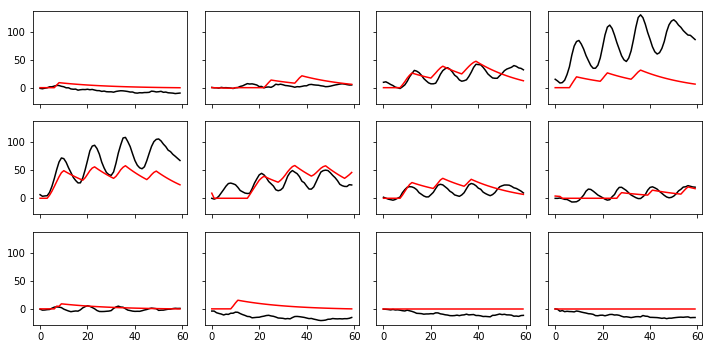

In [68]:
plot_data([T4_Gcamp[10:70,:], T4_model[10:70,:]])

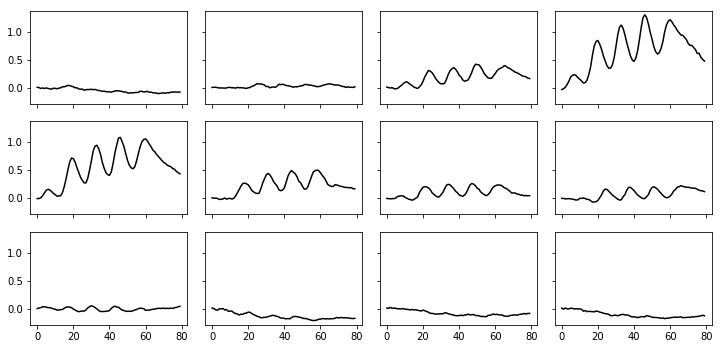

In [19]:
plot_data([T4_Gcamp])

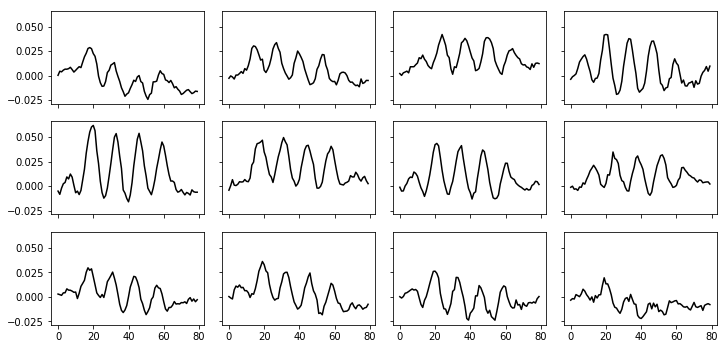

In [5]:
plot_data([T4_Arclight])

In [61]:
# #CalciumModel 1
error_list = []
para_dict = {}
counter = 0
for thres in thres_val:
    for tauhp in tauhp_val:
        for taulp1 in taulp1_val:
            for gain1 in gain1_val:
                T4Ca_model = Ca_model_1(T4_Arclight, thres, tauhp, taulp1, gain1)
                T4Ca_model = shift_signal(T4_Gcamp, T4Ca_model, vel=30.0)
                #T4Ca_model = shift_signal(T4_Gcamp, T4Ca_model) #align signals
                error1 = np.mean(np.sqrt(np.mean((T4_Gcamp[10:65]-T4Ca_model[10:65])**2,axis=0)))
                error2 = np.sqrt(np.mean((T4_Gcamp.max(axis=0)-T4Ca_model.max(axis=0))**2)) #peakerror
                timeerror = 0.8 #weight for time error
                error = timeerror*error1 + (1.0-timeerror)*error2 #peak error aand time error combined
                error_list.append(error)
                para_dict[counter] = (thres, tauhp, taulp1, gain1)
                counter +=1

In [62]:
model_p = para_dict[np.argmin(error_list)]
(thres_model, tauhp_model, taulp1_model, gain_model) = model_p
(np.min(error_list),thres_model, tauhp_model, taulp1_model, gain_model)

(20.001514427391673, 3.888888888888889, 2.0, 10.0, 444.44444444444446)

In [63]:
T4_model = Ca_model_1(T4_Arclight, thres_model, tauhp_model, taulp1_model, gain_model)
T4_model = shift_signal(T4_Gcamp, T4_model, vel=30.0)

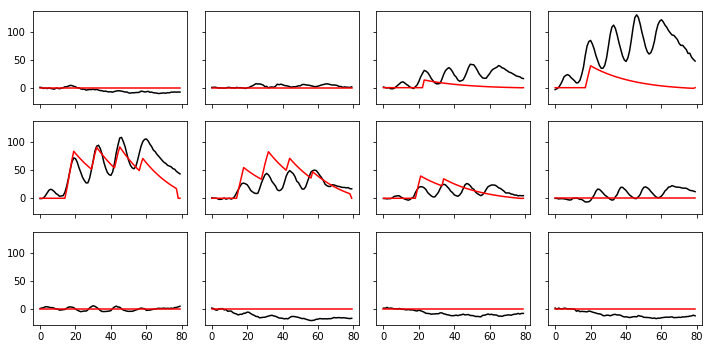

In [64]:
plot_data([T4_Gcamp, T4_model])

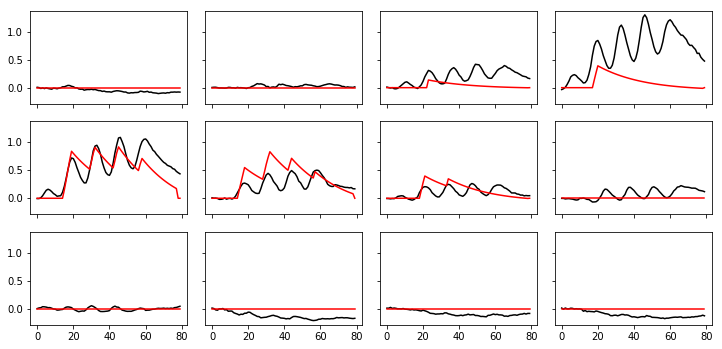

In [57]:
plot_data([T4_Gcamp, T4_model])